In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.src.layers import Dense
from keras.src.layers import LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.src.optimizers import Adam, RMSprop
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
import math
from sklearn.metrics import mean_squared_error
import datetime
import mplfinance as mpf
import math 
import os
import plotly.graph_objects as go
import tensorflow as tf


df = pd.read_csv('/Users/leo/Desktop/Invest_hub/data/historical_data/VKCO_4h.csv')

In [9]:
def str_to_datetime(s):
    date_part, time_part = s.split(' ')[0], s.split(' ')[1].split('+')[0]
    year, month, day = map(int, date_part.split('-'))
    hour, _, _ = map(int, time_part.split(':'))
    return datetime.datetime(year=year, month=month, day=day, hour=hour, minute=0, second=0)

df['Time'] = df['Time'].apply(str_to_datetime)

def specific_data(start, end):
    data = df
    filtered_data = data[(data['Time'] >= start) & (data['Time'] <= end)]
    return filtered_data

start_time = df['Time'].iloc[0]
end_time = df['Time'].iloc[-35]
spec_df = specific_data(start_time, end_time)

In [10]:
new_df = spec_df['Close'].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1, 1))

train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

n_past = 150  # Увеличено окно
n_future = 28  # Прогнозируем 7 дней (28 * 4 часа)
X_train, y_train = [], []
for i in range(n_past, len(train_data) - n_future):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i:i + n_future, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data) - n_future):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i:i + n_future, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.5759 - val_loss: 0.2698
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.1739 - val_loss: 0.1977
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.1119 - val_loss: 0.1275
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0760 - val_loss: 0.1054
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0556 - val_loss: 0.1198
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0439 - val_loss: 0.0497
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0341 - val_loss: 0.0425
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0278 - val_loss: 0.0616
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0221 - val_loss: 0.0375
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0192 - val_loss: 0.0238
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0172 - val_loss: 0.0150
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step

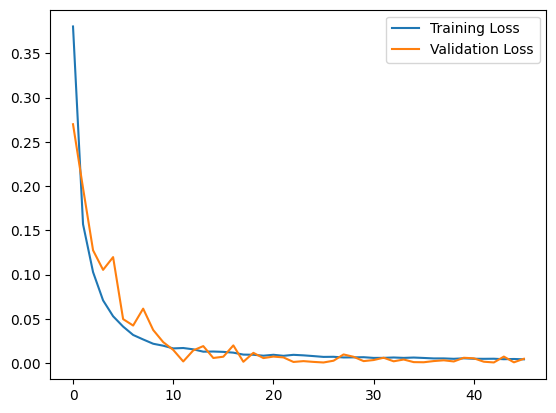

In [14]:


model = Sequential()

# Добавление Conv1D и MaxPooling1D слоев
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=128))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=n_future))

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')

checkpoints = ModelCheckpoint(filepath='my_weights.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoints, early_stopping]
)


In [17]:
last_sequence = X_test[-1]
look_back = 150
last_sequence = last_sequence.reshape(1, look_back, 1)

predictions_next_7_days = []
for _ in range(7):
    daily_predictions = []
    for _ in range(4):
        next_hour_prediction = model.predict(last_sequence)
        daily_predictions.append(next_hour_prediction[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = next_hour_prediction[0, 0]
    predictions_next_7_days.extend(daily_predictions)

predictions_next_7_days = scaler.inverse_transform(np.array(predictions_next_7_days).reshape(-1, 1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [20]:
real_data_next_7_days = specific_data(df['Time'].iloc[-35], df['Time'].iloc[-1])
real_dates = pd.to_datetime(real_data_next_7_days['Time'])
real_prices = real_data_next_7_days['Close'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=real_dates, y=real_prices, mode='lines', name='Actual Prices', line=dict(color='black')))
fig.add_trace(go.Scatter(x=real_dates[:len(predictions_next_7_days)], y=predictions_next_7_days.flatten(), mode='lines+markers', name='Predicted Prices', line=dict(color='blue')))
fig.update_layout(title='Actual vs Predicted Stock Prices', xaxis_title='Time', yaxis_title='Price', legend=dict(x=0, y=1), template='plotly_white')
fig.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

